🚀 BERTopic 主题建模
📂 加载数据: merged_transcripts.csv
   原始: 102 行
   清洗后: 101 行

📊 各类别:
   类别 1: 53 个
   类别 2: 28 个
   类别 3: 20 个

📌 处理类别 2 (28 个文档)

🔍 BERTopic (n_docs=28, min_cluster=3)
   📋 UMAP: n_neighbors=2, n_components=8, min_dist=0.0
   📋 HDBSCAN: min_cluster=3, min_samples=1, epsilon=0.0
   ⏳ 生成 embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


   ⏳ 步骤1: UMAP 降维到 2D（用于可视化）...
   📊 查看 UMAP 降维效果...
   💾 bertopic_outputs_mia_cat2/cat2_step1_umap_only.png


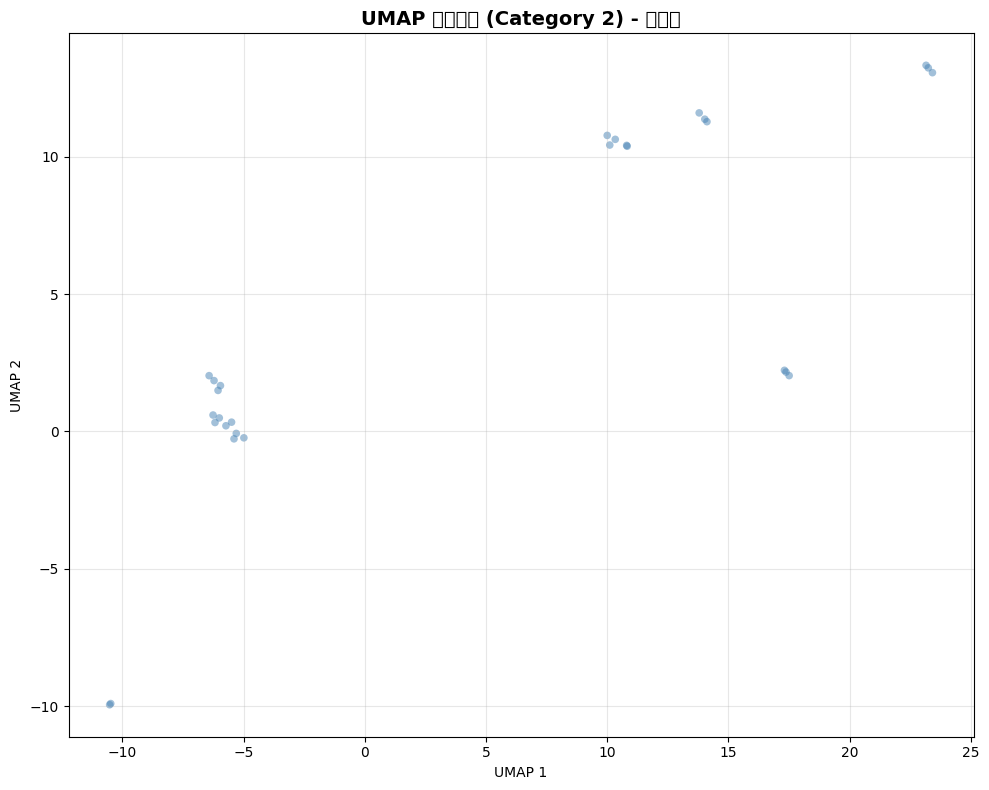


   ⏳ 步骤2: UMAP 降维到 8D（用于聚类）...

   ⏳ 步骤3: HDBSCAN 聚类...
   ✓ 发现 7 个主题
   ✓ 离群点: 0 (0.0%)

   📊 步骤4: 查看 HDBSCAN 聚类结果...
   💾 bertopic_outputs_mia_cat2/cat2_step2_hdbscan_clusters.png


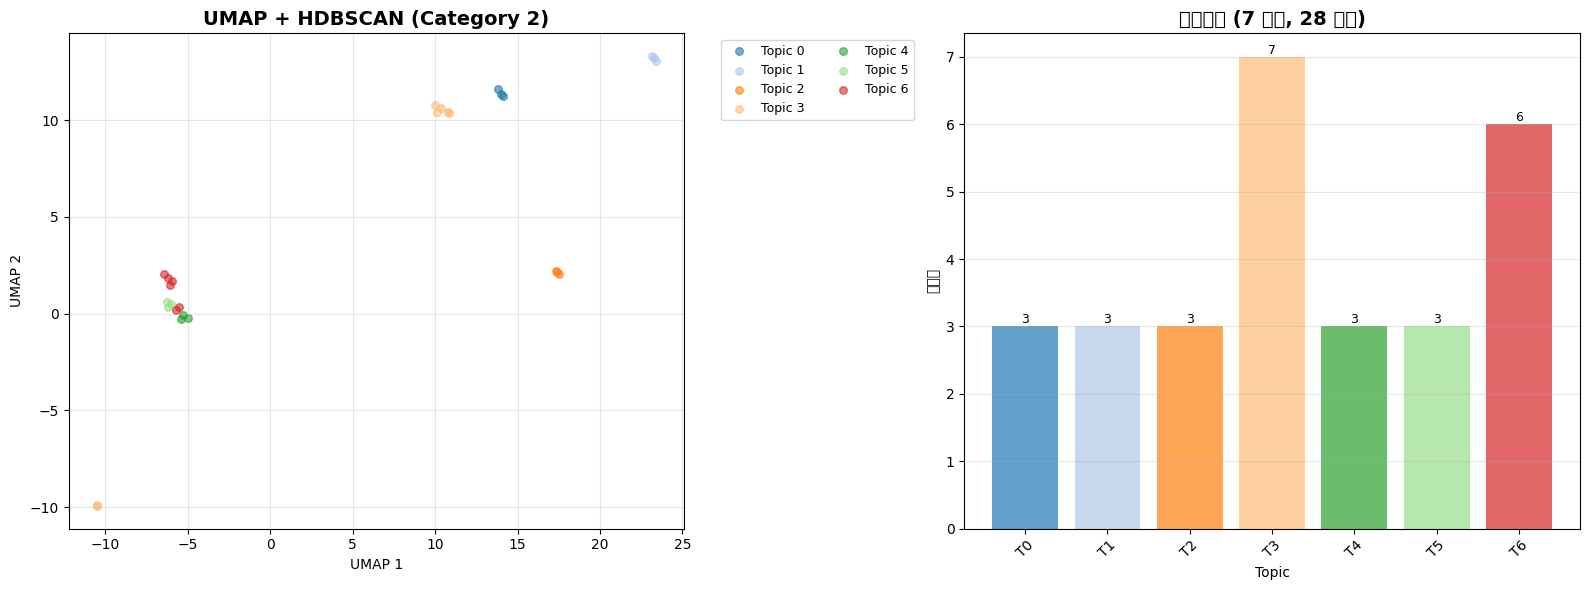


📈 聚类统计:
   总文档: 28
   主题数: 7
   离群点: 0 (0.0%)
   Topic 0: 3 docs (10.7%)
   Topic 1: 3 docs (10.7%)
   Topic 2: 3 docs (10.7%)
   Topic 3: 7 docs (25.0%)
   Topic 4: 3 docs (10.7%)
   Topic 5: 3 docs (10.7%)
   Topic 6: 6 docs (21.4%)

   ⏳ 步骤5: 提取主题关键词...

💾 保存结果...
   ✓ doc_topics.csv
   ✓ topic_info.csv
   ✓ topic_words.csv

📊 生成可视化...
   ⚠️ barchart 失败: visualize_barchart() got an unexpected keyword argument 'top_n_words'
   ✓ hierarchy.html

✅ 完成！结果在 bertopic_outputs_mia_cat2/


In [17]:
"""
BERTopic 主题建模 - 简化版
所有参数在顶部，方便调整
"""

# ============================================================
# ⚙️ 参数设置区 - 只需要改这里！
# ============================================================

# 文件配置
INPUT_CSV = "merged_transcripts.csv"
OUTPUT_DIR = "bertopic_outputs_mia_cat2"
TEST_CATEGORY = 2  # 测试哪个类别 (1/2/3)

# UMAP 参数
UMAP_N_NEIGHBORS = 2     # 点太分散？改成 30-50
UMAP_N_COMPONENTS = 8     # 聚类维度（5-10）
UMAP_MIN_DIST = 0.0       # 0.0=紧密，0.3=松散

# HDBSCAN 参数
HDBSCAN_MIN_CLUSTER_SIZE = 3   # ⚠️ 最重要！控制主题数量
                                # 3-5 = 很多主题
                                # 8-10 = 中等主题
                                # 15-20 = 很少主题
                                # None = 自动计算

HDBSCAN_MIN_SAMPLES = 1        # 1=宽松，10=严格
HDBSCAN_EPSILON = 0.0          # 0.0=不合并，1.0=合并相似主题

# 其他参数
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
TOP_N_WORDS = 12
RANDOM_STATE = 42

# ============================================================
# 以下是代码实现（一般不需要修改）
# ============================================================

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN

# NLTK for stopwords and lemmatization
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

try:
    from nltk.corpus import stopwords
    NLTK_STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords', quiet=True)
    from nltk.corpus import stopwords
    NLTK_STOPWORDS = set(stopwords.words('english'))

# Download wordnet for lemmatization
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    print("Downloading WordNet...")
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)

YOUTUBE_STOPWORDS = {
    "subscribe", "channel", "video", "like", "comment",
    "watch", "watching", "click", "follow", "share",
    "uh", "um", "yeah", "hey", "guys", "okay", "ok",
    "thing", "things", "gonna", "kind", "sort", "lot",
    "really", "going", "say", "know", "want", "see", "think", "just", "u"
}

STOPWORDS = NLTK_STOPWORDS.union(YOUTUBE_STOPWORDS)
LEMMATIZER = WordNetLemmatizer()


def clean_text(text):
    """清洗文本"""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"[^a-z\s']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


def tokenize_and_stem(text):
    """分词、去停用词、词形还原"""
    text = clean_text(text)
    tokens = text.split()
    result = []
    for token in tokens:
        if token in STOPWORDS:
            continue
        lemma = LEMMATIZER.lemmatize(token)
        if lemma and lemma not in STOPWORDS:
            result.append(lemma)
    return result


def load_data():
    """加载数据"""
    print(f"📂 加载数据: {INPUT_CSV}")
    df = pd.read_csv(INPUT_CSV)
    print(f"   原始: {len(df)} 行")

    # 标准化类别
    def parse_cat(val):
        m = re.search(r"\b([123])\b", str(val))
        return int(m.group(1)) if m else np.nan

    df["Influencer/Mainstream"] = df["Influencer/Mainstream"].apply(parse_cat)
    df = df[df["Influencer/Mainstream"].isin([1, 2, 3])]

    # 清洗文本
    df["full_transcript"] = df["full_transcript"].astype(str).map(clean_text)
    df = df[df["full_transcript"].str.len() > 30]
    df = df.dropna(subset=["full_transcript", "Influencer/Mainstream"])
    df["video_id"] = df["video_id"].astype(str)

    print(f"   清洗后: {len(df)} 行")
    print("\n📊 各类别:")
    for cat in [1, 2, 3]:
        print(f"   类别 {cat}: {len(df[df['Influencer/Mainstream'] == cat])} 个")

    return df.reset_index(drop=True)


def create_vectorizer(n_docs):
    """创建向量化器"""
    if n_docs < 100:
        max_df, min_df = 1.0, 1
    else:
        max_df, min_df = 0.95, 2

    return CountVectorizer(
        analyzer=tokenize_and_stem,
        ngram_range=(1, 2),
        max_df=max_df,
        min_df=min_df
    )


def plot_umap_only(umap_2d, category):
    """只画 UMAP 降维结果（无聚类标签）"""
    fig, ax = plt.subplots(figsize=(10, 8))

    ax.scatter(umap_2d[:, 0], umap_2d[:, 1],
               c='steelblue', s=30, alpha=0.5, edgecolors='none')

    ax.set_title(f'UMAP 降维结果 (Category {category}) - 未聚类',
                fontsize=14, fontweight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.grid(alpha=0.3)

    plt.tight_layout()
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    filepath = os.path.join(OUTPUT_DIR, f"cat{category}_step1_umap_only.png")
    fig.savefig(filepath, dpi=150, bbox_inches='tight')
    print(f"   💾 {filepath}")
    plt.show()


def plot_clusters(umap_2d, clusters, category):
    """绘制聚类可视化"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    unique = np.unique(clusters)
    n_topics = len([t for t in unique if t != -1])
    colors = plt.cm.tab20(np.linspace(0, 1, max(20, len(unique))))

    # 左图：散点图
    ax1 = axes[0]
    for tid in unique:
        mask = clusters == tid
        if tid == -1:
            ax1.scatter(umap_2d[mask, 0], umap_2d[mask, 1],
                       c='lightgray', s=20, alpha=0.3, label='Outliers')
        else:
            ax1.scatter(umap_2d[mask, 0], umap_2d[mask, 1],
                       c=[colors[tid % len(colors)]], s=30, alpha=0.6,
                       label=f'Topic {tid}')

    ax1.set_title(f'UMAP + HDBSCAN (Category {category})', fontsize=14, fontweight='bold')
    ax1.set_xlabel('UMAP 1')
    ax1.set_ylabel('UMAP 2')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=2)
    ax1.grid(alpha=0.3)

    # 右图：统计
    ax2 = axes[1]
    counts = pd.Series(clusters).value_counts().sort_index()
    bar_colors = ['lightgray' if t == -1 else colors[t % len(colors)] for t in counts.index]
    bars = ax2.bar(range(len(counts)), counts.values, color=bar_colors, alpha=0.7)
    ax2.set_xticks(range(len(counts)))
    ax2.set_xticklabels([f'T{t}' if t != -1 else 'Out' for t in counts.index], rotation=45)
    ax2.set_title(f'文档分布 ({n_topics} 主题, {len(clusters)} 文档)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Topic')
    ax2.set_ylabel('文档数')
    ax2.grid(axis='y', alpha=0.3)

    for bar, count in zip(bars, counts.values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                str(count), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    filepath = os.path.join(OUTPUT_DIR, f"cat{category}_step2_hdbscan_clusters.png")
    fig.savefig(filepath, dpi=150, bbox_inches='tight')
    print(f"   💾 {filepath}")
    plt.show()

    # 打印统计
    print(f"\n📈 聚类统计:")
    print(f"   总文档: {len(clusters)}")
    print(f"   主题数: {n_topics}")
    print(f"   离群点: {np.sum(clusters == -1)} ({np.sum(clusters == -1)/len(clusters)*100:.1f}%)")
    for tid, count in counts.items():
        if tid != -1:
            print(f"   Topic {tid}: {count} docs ({count/len(clusters)*100:.1f}%)")


def run_bertopic(docs, category):
    """运行 BERTopic"""
    n_docs = len(docs)

    # 确定 min_cluster_size
    if HDBSCAN_MIN_CLUSTER_SIZE is None:
        min_cluster = max(2, min(8, n_docs // 5))
        print(f"\n🔍 BERTopic (n_docs={n_docs}, 自动 min_cluster={min_cluster})")
    else:
        min_cluster = HDBSCAN_MIN_CLUSTER_SIZE
        print(f"\n🔍 BERTopic (n_docs={n_docs}, min_cluster={min_cluster})")

    print(f"   📋 UMAP: n_neighbors={UMAP_N_NEIGHBORS}, n_components={UMAP_N_COMPONENTS}, min_dist={UMAP_MIN_DIST}")
    print(f"   📋 HDBSCAN: min_cluster={min_cluster}, min_samples={HDBSCAN_MIN_SAMPLES}, epsilon={HDBSCAN_EPSILON}")

    # 1. Embeddings
    print(f"   ⏳ 生成 embeddings...")
    embedding_model = SentenceTransformer(EMBEDDING_MODEL)
    embeddings = embedding_model.encode(docs, show_progress_bar=True)

    # 2. UMAP 降维（先降到 2D 用于可视化）
    print(f"\n   ⏳ 步骤1: UMAP 降维到 2D（用于可视化）...")
    umap_2d = UMAP(
        n_components=2,
        n_neighbors=min(UMAP_N_NEIGHBORS, n_docs - 1),
        min_dist=UMAP_MIN_DIST,
        metric='cosine',
        random_state=RANDOM_STATE
    )
    umap_2d_embeddings = umap_2d.fit_transform(embeddings)
    print(f"   📊 查看 UMAP 降维效果...")
    plot_umap_only(umap_2d_embeddings, category)

    # 3. UMAP 降维（用于聚类的高维版本）
    print(f"\n   ⏳ 步骤2: UMAP 降维到 {UMAP_N_COMPONENTS}D（用于聚类）...")
    umap_model = UMAP(
        n_neighbors=min(UMAP_N_NEIGHBORS, n_docs - 1),
        n_components=UMAP_N_COMPONENTS,
        min_dist=UMAP_MIN_DIST,
        metric="cosine",
        random_state=RANDOM_STATE
    )
    umap_embeddings = umap_model.fit_transform(embeddings)

    # 4. HDBSCAN 聚类
    print(f"\n   ⏳ 步骤3: HDBSCAN 聚类...")
    hdbscan_kwargs = {
        'min_cluster_size': min_cluster,
        'min_samples': HDBSCAN_MIN_SAMPLES,
        'metric': 'euclidean',
        'cluster_selection_method': 'eom',
        'prediction_data': True
    }
    if HDBSCAN_EPSILON > 0:
        hdbscan_kwargs['cluster_selection_epsilon'] = HDBSCAN_EPSILON

    hdbscan_model = HDBSCAN(**hdbscan_kwargs)
    clusters = hdbscan_model.fit_predict(umap_embeddings)

    n_topics = len([t for t in np.unique(clusters) if t != -1])
    n_outliers = np.sum(clusters == -1)
    print(f"   ✓ 发现 {n_topics} 个主题")
    print(f"   ✓ 离群点: {n_outliers} ({n_outliers/len(clusters)*100:.1f}%)")

    # 5. 可视化聚类结果
    print(f"\n   📊 步骤4: 查看 HDBSCAN 聚类结果...")
    plot_clusters(umap_2d_embeddings, clusters, category)

    # 6. 提取主题词
    print(f"\n   ⏳ 步骤5: 提取主题关键词...")
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=create_vectorizer(n_docs),
        top_n_words=TOP_N_WORDS,
        calculate_probabilities=False,
        verbose=False
    )
    topics, _ = topic_model.fit_transform(docs, embeddings)

    # 减少离群点
    try:
        before = np.sum(topics == -1)
        topics = topic_model.reduce_outliers(docs, topics)
        after = np.sum(topics == -1)
        if before != after:
            print(f"   ✓ 减少离群点: {before} → {after}")
    except:
        pass

    return topic_model, topics


def save_results(topic_model, topics, ids, category):
    """保存结果"""
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"\n💾 保存结果...")

    # 1. 文档-主题
    doc_df = pd.DataFrame({"video_id": ids, "topic": topics})
    doc_df.to_csv(f"{OUTPUT_DIR}/cat{category}_doc_topics.csv", index=False)
    print(f"   ✓ doc_topics.csv")

    # 2. 主题信息
    topic_info = topic_model.get_topic_info()
    topic_info.to_csv(f"{OUTPUT_DIR}/cat{category}_topic_info.csv", index=False)
    print(f"   ✓ topic_info.csv")

    # 3. 主题词
    rows = []
    for tid in topic_info["Topic"]:
        if tid == -1:
            continue
        for rank, (word, weight) in enumerate(topic_model.get_topic(tid), 1):
            rows.append({"topic": tid, "rank": rank, "word": word, "weight": weight})

    words_df = pd.DataFrame(rows)
    words_df.to_csv(f"{OUTPUT_DIR}/cat{category}_topic_words.csv", index=False)
    print(f"   ✓ topic_words.csv")

    # 4. 可视化
    print(f"\n📊 生成可视化...")
    try:
        fig = topic_model.visualize_barchart(top_n_topics=None, top_n_words=TOP_N_WORDS)
        fig.write_html(f"{OUTPUT_DIR}/cat{category}_barchart.html")
        print(f"   ✓ barchart.html")
    except Exception as e:
        print(f"   ⚠️ barchart 失败: {e}")

    try:
        fig = topic_model.visualize_hierarchy()
        fig.write_html(f"{OUTPUT_DIR}/cat{category}_hierarchy.html")
        print(f"   ✓ hierarchy.html")
    except Exception as e:
        print(f"   ⚠️ hierarchy 失败: {e}")

    print(f"\n✅ 完成！结果在 {OUTPUT_DIR}/")


def main():
    """主函数"""
    print("="*60)
    print("🚀 BERTopic 主题建模")
    print("="*60)

    # 加载数据
    df = load_data()

    # 选择类别
    df_cat = df[df["Influencer/Mainstream"] == TEST_CATEGORY].reset_index(drop=True)
    docs = df_cat["full_transcript"].tolist()
    ids = df_cat["video_id"].tolist()

    print(f"\n{'='*60}")
    print(f"📌 处理类别 {TEST_CATEGORY} ({len(docs)} 个文档)")
    print(f"{'='*60}")

    # 运行 BERTopic
    topic_model, topics = run_bertopic(docs, TEST_CATEGORY)

    # 保存结果
    save_results(topic_model, topics, ids, TEST_CATEGORY)


if __name__ == "__main__":
    main()

📂 Loaded: bertopic_outputs_mia_cat2/cat2_topic_words.csv
   Topics found: 7
   Plotting 7 topics...

✅ Saved: bertopic_outputs_mia_cat2/cat2_topic_words_barchart.png


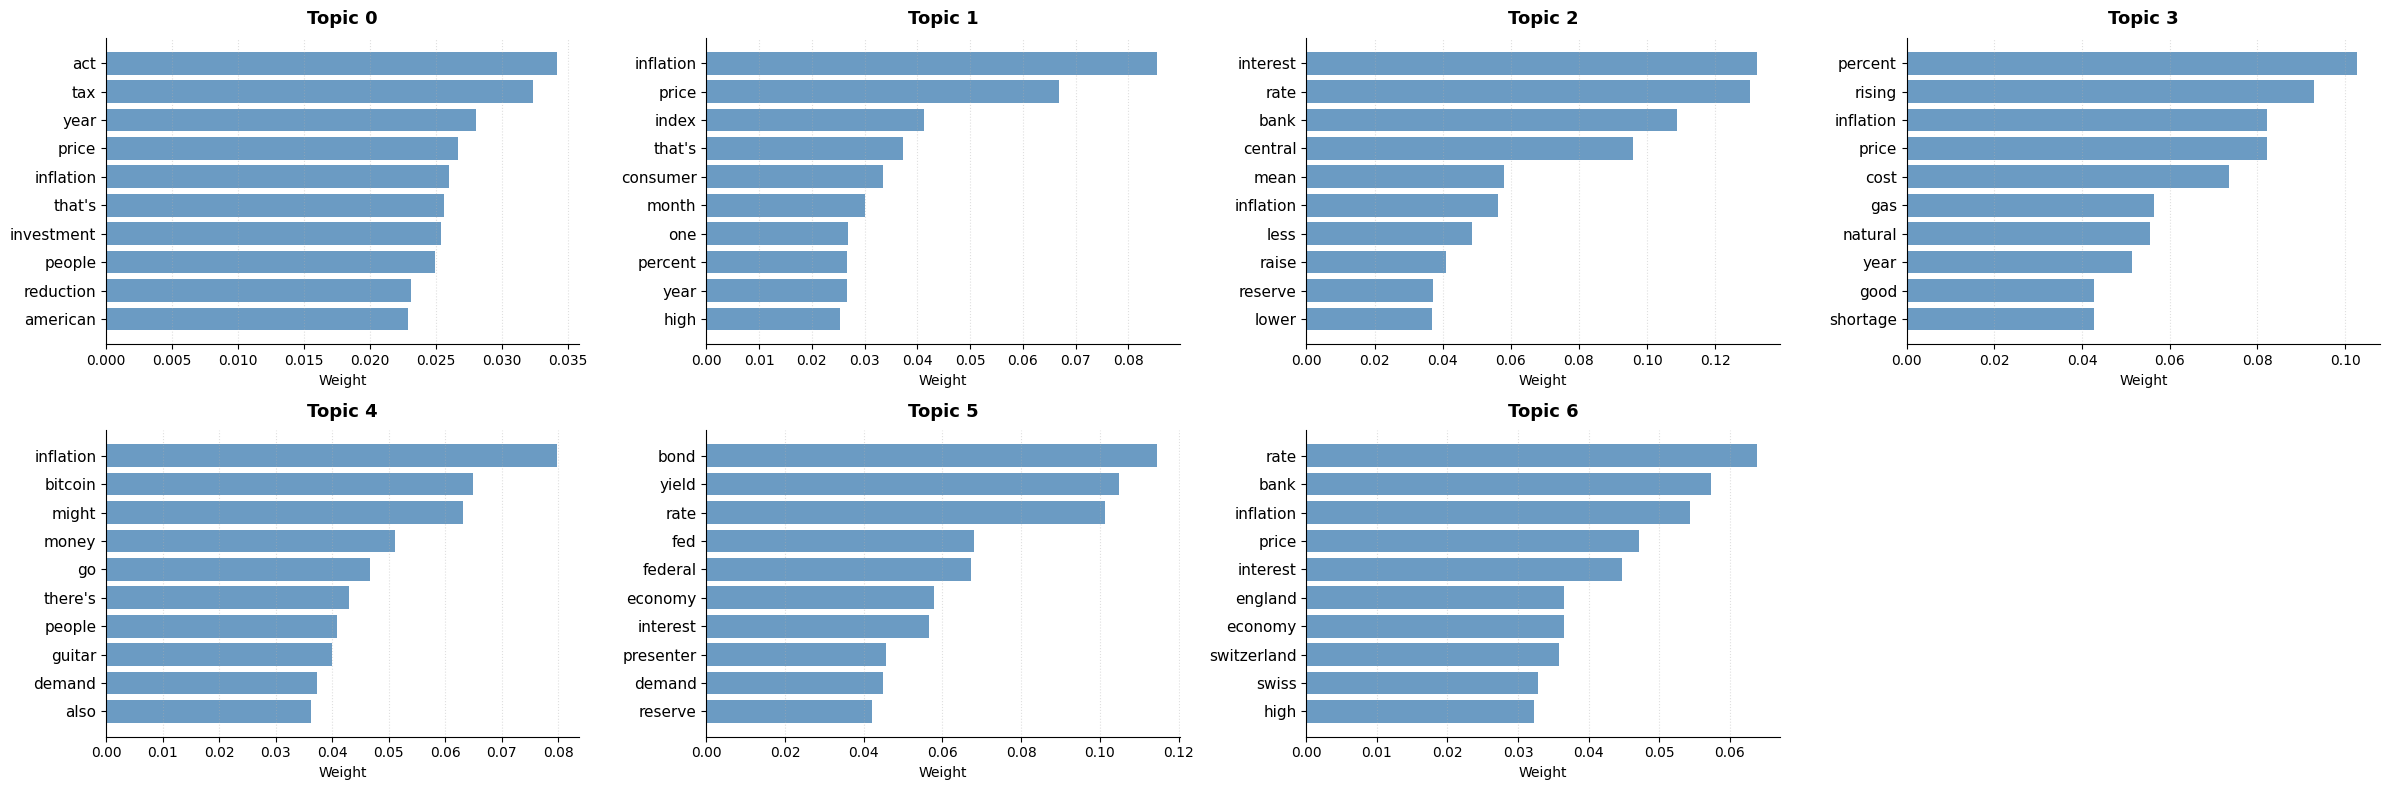

In [18]:
"""
Plot Topic Words Bar Chart from BERTopic Results
Directly load from topic_words.csv and create visualization
"""

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# Configuration
# ============================================================
OUTPUT_DIR = "bertopic_outputs_mia_cat2"  # Change to your output folder
CATEGORY = 2                              # Which category
TOP_N_WORDS = 10                          # How many words to show per topic

# ============================================================
# Load and Plot
# ============================================================

# Load topic words data
topic_words_file = os.path.join(OUTPUT_DIR, f"cat{CATEGORY}_topic_words.csv")
df_words = pd.read_csv(topic_words_file)

print(f"📂 Loaded: {topic_words_file}")
print(f"   Topics found: {df_words['topic'].nunique()}")

# Get unique topics (sorted)
topics = sorted(df_words['topic'].unique())
n_topics = len(topics)

print(f"   Plotting {n_topics} topics...")

# Calculate grid layout
ncols = min(4, n_topics) if n_topics >= 4 else min(2, n_topics)
nrows = int(math.ceil(n_topics / ncols))

# Create figure
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(6 * ncols, 4 * nrows),
    squeeze=False
)

# Plot each topic
for idx, topic_id in enumerate(topics):
    row = idx // ncols
    col = idx % ncols
    ax = axes[row][col]

    # Get top words for this topic
    topic_data = df_words[df_words['topic'] == topic_id].sort_values('rank').head(TOP_N_WORDS)

    words = topic_data['word'].tolist()
    weights = topic_data['weight'].tolist()

    # Reverse order (highest weight on top)
    words = list(reversed(words))
    weights = list(reversed(weights))

    # Plot horizontal bar chart
    y_pos = np.arange(len(words))
    ax.barh(y_pos, weights, color='steelblue', alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(words, fontsize=11)
    ax.set_xlabel('Weight', fontsize=10)
    ax.set_title(f'Topic {topic_id}', fontsize=13, fontweight='bold', pad=10)
    ax.grid(axis='x', linestyle=':', alpha=0.4)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Hide empty subplots
total_plots = nrows * ncols
for j in range(n_topics, total_plots):
    axes[j // ncols][j % ncols].axis('off')

plt.tight_layout()

# Save figure
output_file = os.path.join(OUTPUT_DIR, f"cat{CATEGORY}_topic_words_barchart.png")
fig.savefig(output_file, dpi=150, bbox_inches='tight')
print(f"\n✅ Saved: {output_file}")

# Also show the plot
plt.show()